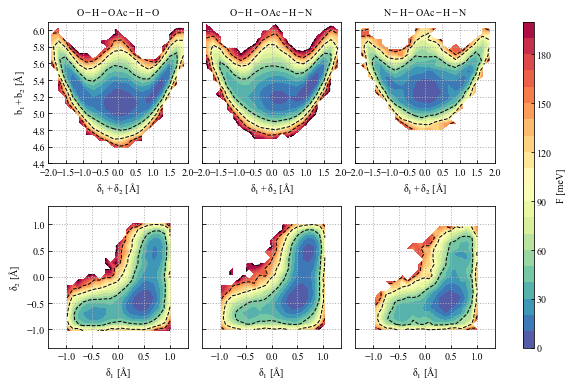

In [289]:
%matplotlib inline

from glob import glob

import matplotlib.pyplot as plt
import numpy as np

f, axs = plt.subplots(2, 3, figsize=[10, 6], sharey="row", sharex="row")

all_xax = np.concatenate(
    #[np.load(fname) for fname in glob("../analyses/hbonds/nvt-*/*/xax.npy")],
    [np.load(fname) for fname in glob("../analyses/hbonds/al-adam-gen3/nvt-340k-100ps/*/xax.npy")],
    axis=0,
)
all_count = all_xax.shape[0]

for ((ax1, ax2), name, i) in zip(axs.T, ["aaa", "aab", "bab"], [0.0, 1.0, 2.0]):
    this_xax = all_xax[all_xax[:, 0] == i]
    def hist2contour(ax, x, y):
        h, xedges, yedges = np.histogram2d(x, y, bins=20)
        pmf = - np.ma.log(h.T/all_count) * 8.617e-5 * 340 * 1000
        pmf -= np.min(pmf)
        xbins = xedges[:-1] + (xedges[1] - xedges[0]) / 2
        ybins = yedges[:-1] + (yedges[1] - yedges[0]) / 2
        level1 = np.arange(0, 201, 10)
        level2 = np.arange(0, 201, 50)
        c = ax.contourf(xbins, ybins, pmf, level1,cmap='Spectral_r')
        ax.contour(xbins, ybins, pmf, level2, colors="k", linewidths=1, linestyles='--')
        return c
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(4.5, 6.1)
    ax2.set_xlim(-1.35, 1.35)
    ax2.set_ylim(-1.35, 1.35)
    ax2.set_xticks(np.arange(-1,1.1,0.5))
    ax1.set_xticks(np.arange(-2,2.1,0.5))
    ax1.set_yticks(np.arange(4.4,6.1,0.2))
    
    ax1.grid(lw=1, ls=':')
    ax2.grid(lw=1, ls=':')
    ax1.set_xlabel('$\delta_1+\delta_2~[\AA]$')
    ax2.set_xlabel('$\delta_1~[\AA]$')
    if i==0.:
        ax2.set_ylabel('$\delta_2~[\AA]$')
        ax1.set_ylabel('$b_1+b_2~[\AA]$')
    
    c = hist2contour(ax1, this_xax[:, 1:] @ [-1, 1, -1, 1], this_xax[:, 1:] @ [1, 1, 1, 1])
    hist2contour(ax2, this_xax[:, 1:] @ [-1, 1, 0, 0], this_xax[:, 1:] @ [0, 0, -1, 1])

plt.subplots_adjust(wspace=0.1, hspace=0.3)
f.colorbar(c, ax=axs.flatten().tolist(), aspect=30, label='F [meV]')
axs[0,0].set_title('$O-H-OAc-H-O$',fontsize=10)
axs[0,1].set_title('$O-H-OAc-H-N$',fontsize=10)
axs[0,2].set_title('$N-H-OAc-H-N$',fontsize=10)
# plt.savefig('pt-pmf-cp2k.png')
plt.savefig('pt-pmf-al-adam-gen3.png')

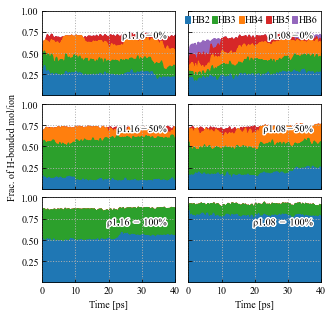

In [271]:
from scipy.signal import savgol_filter
import matplotlib.patheffects as pe

f, axs = plt.subplots(3,2, figsize=[5,5], sharex=True, sharey=True)
stride = 20

for rho, col, t1 in zip(['rho1.1551', 'rho1.0753'], axs.T, [r'$\rho1.16',r'$\rho1.08']):
    
    for tag, ax, t2 in zip(['a32b32i0','a16b16i16','a0b0i32'], col, ['-0\%$', '-50\%$', '~-~100\%$']):
        ener = np.concatenate([np.loadtxt(f'../trajs/cp2k/nvt-{seg}-{seg+10}ps/hoac-c1im-{tag}-{rho}/cp2k-md-1.ener') for seg in [0,10,20,30]],axis=0)
        traj = np.concatenate([np.load(f'../analyses/hbonds/nvt-{seg}-{seg+10}ps/hoac-c1im-{tag}-{rho}/pop.npy') for seg in [0,10,20,30]],axis=0)
        traj = traj[::stride]
        ener = ener[::stride]
        t = ener[:,1]/1000
        pot = ener[:,4]/640*27.2114
        # for the HB population
        hbpop = traj[:,3:].cumsum(axis=1)/64.
        hbpop = np.apply_along_axis(lambda m: savgol_filter(m, 101, 3), axis=0, arr=hbpop)
        handles = [ax.fill_between(t, x, color=color, alpha=1) for x, color in 
                   list(zip(hbpop.T, ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple']))[::-1]]
        # for the plot
        ax.text(0.95,0.7, t1+t2,transform=ax.transAxes, va='center', ha='right', 
                path_effects=[pe.withStroke(linewidth=3, foreground='w')])
        ax.grid(lw=1, ls=':')
axs[1,0].set_ylabel('Frac. of H-bonded mol/ion')
axs[-1,0].set_xlabel('Time [ps]')
axs[-1,1].set_xlabel('Time [ps]')
        
axs[0,1].legend(handles[::-1], [f'HB{i+2}' for i in range(len(handles))], 
                handlelength=0.5, ncol=5, columnspacing=0.2, handletextpad=0.1, borderaxespad=0)
ax.set_ylim(0.001,1)
ax.set_xlim(0,40)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('hbnet-cp2k.png')

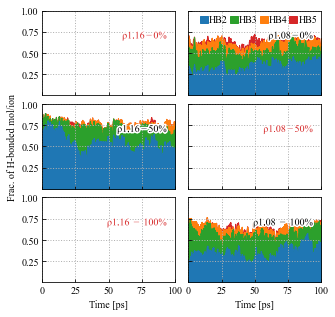

In [270]:
from scipy.signal import savgol_filter
import matplotlib.patheffects as pe
from os.path import exists

f, axs = plt.subplots(3,2, figsize=[5,5], sharex=True, sharey=True)
stride = 1

for rho, col, t1 in zip(['r1.16', 'r1.08'], axs.T, [r'$\rho1.16',r'$\rho1.08']):
    for tag, ax, t2 in zip(['m32i0','m16i16','m0i32'], col, ['-0\%$', '-50\%$', '~-~100\%$']):
        # ener = np.concatenate([np.loadtxt(f'../trajs/cp2k/nvt-{seg}-{seg+10}ps/hoac-c1im-{tag}-{rho}/cp2k-md-1.ener') for seg in [0,10,20,30]],axis=0)
        #traj = np.concatenate([np.load(f'../analyses/hbonds/nvt-{seg}-{seg+10}ps/hoac-c1im-{tag}-{rho}/pop.npy') for seg in [0,10,20,30]],axis=0)
        if not exists(f'../analyses/hbonds/al-adam-gen3/nvt-340k-100ps/{tag}-{rho}/pop.npy'):
            ax.text(0.95,0.7, t1+t2,transform=ax.transAxes, va='center', ha='right', 
                    color='tab:red', path_effects=[pe.withStroke(linewidth=3, foreground='w')])
            ax.grid(lw=1, ls=':')
            continue
        traj = np.load(f'../analyses/hbonds/al-adam-gen3/nvt-340k-100ps/{tag}-{rho}/pop.npy') 
        traj = traj[::stride]
        t = np.arange(traj.shape[0])/100*stride
        # for the HB population
        hbpop = traj[:,3:].cumsum(axis=1)/64.
        hbpop = np.apply_along_axis(lambda m: savgol_filter(m, 101, 3), axis=0, arr=hbpop)
        handles = [ax.fill_between(t, x, color=color, alpha=1) for x, color in 
                   list(zip(hbpop.T, ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']))[::-1]]
        # for the plot
        ax.text(0.95,0.7, t1+t2,transform=ax.transAxes, va='center', ha='right', 
                path_effects=[pe.withStroke(linewidth=3, foreground='w')])
        ax.grid(lw=1, ls=':')
axs[1,0].set_ylabel('Frac. of H-bonded mol/ion')
axs[-1,0].set_xlabel('Time [ps]')
axs[-1,1].set_xlabel('Time [ps]')
        
axs[0,1].legend(handles[::-1], [f'HB{i+2}' for i in range(len(handles))], 
                handlelength=0.8, ncol=4, columnspacing=0.2, handletextpad=0.1, borderaxespad=0)
ax.set_ylim(0.001,1.0)
ax.set_xlim(0,100)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('hbnet-al-adam-gen3.png')